# Background rejection exercise

We will implement a multi-variate analysis for suppressing the irreducible background in H -> ZZ -> 4µ events at the Muon Collider using machine learning.

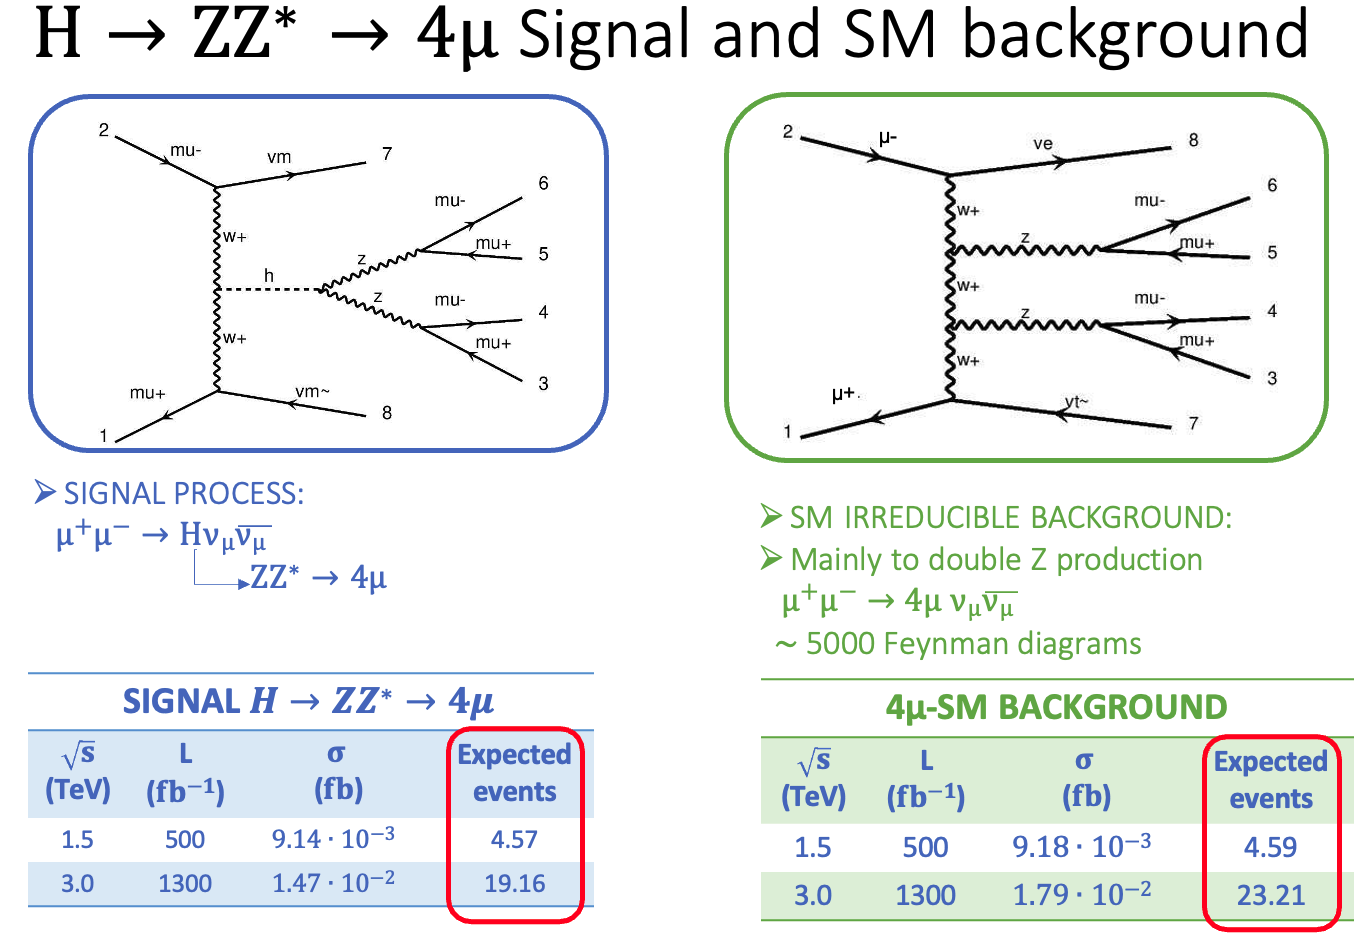

### Import libraries and read input files

In [1]:
!ls

Lect4_BkgSuppression_RVenditti.pdf      MVA_MELA_angVariables_lecture4.C
Lect4_bkgsuppression.pptx               collider_physics_MVA.ipynb
MELA_variables_bkg_200k_1_5Tev_DLF.root ~$Lect4_bkgsuppression.pptx
MELA_variables_sig_50k_1_5Tev_DLF.root


Few useful imports

In [2]:
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import ROOT

ROOT.gROOT.SetBatch(False)

Welcome to JupyROOT 6.30/04


In [3]:
rdf_bkg = ROOT.RDataFrame("T", "MELA_variables_bkg_200k_1_5Tev_DLF.root")
rdf_sig = ROOT.RDataFrame("T", "MELA_variables_sig_50k_1_5Tev_DLF.root")

## Plot input features
Here we assume the input dataframes are in the ROOT RDataFrame format
and we use ROOT for plotting

In [28]:
var_name = "mZ1"
c=ROOT.TCanvas()
#here we assume the input dataframes are in the ROOT RDataFrame format
h_sig = rdf_sig.Histo1D((var_name+' sig', var_name+' sig', 100, 0, 150), var_name)
h_bkg = rdf_bkg.Histo1D((var_name+' bkg', var_name+' bkg', 100, 0, 150), var_name)
#normalise to same entries
h_sig.Scale(1.0/h_sig.GetEntries())
h_bkg.Scale(1.0/h_bkg.GetEntries())
#cosmetics
h_sig.SetLineColor(ROOT.kRed)
h_bkg.SetLineColor(ROOT.kBlue)
h_sig.GetXaxis().SetTitle(var_name)
h_sig.GetYaxis().SetTitle("A.U.")
h_sig.Draw("hist")
h_bkg.Draw("hist same")
c.SetLogy()
c.BuildLegend()
c.Draw()

Look at the content

In [5]:
rdf_bkg.Display().Print()

+-----+--------------+------------+---------------+-----------+-----------+-----------+------------+-----+
| Row | cosTheta_1   | cosTheta_2 | cosTheta_star | mH        | mZ1       | mZ2       | phi        | ... | 
+-----+--------------+------------+---------------+-----------+-----------+-----------+------------+-----+
| 0   | 0.87641631   | 0.74249331 | -0.91018473   | 372.87353 | 92.338289 | 89.957871 | 1.8120773  | ... | 
+-----+--------------+------------+---------------+-----------+-----------+-----------+------------+-----+
| 1   | -0.33873910  | 0.26664890 | -0.89268815   | 246.54164 | 100.44719 | 76.094072 | -1.3742746 | ... | 
+-----+--------------+------------+---------------+-----------+-----------+-----------+------------+-----+
| 2   | 0.061913312  | 0.51564562 | -0.79198794   | 280.54237 | 91.392792 | 112.18041 | 3.0746369  | ... | 
+-----+--------------+------------+---------------+-----------+-----------+-----------+------------+-----+
| 3   | -0.51751296  | 0.86985893

Info in <Print>: Only showing 8 columns out of 10



# Cut-based analysis
Here we implement a tentative cut-based analysis.
For each feature, plot nd set a common-sense cut. Ideally, one should scan over each feature and maximise the signal significance!

In [ ]:
#for each feature, plot and set a common-sense cut. Ideally, one should scan over each feature and maximise the signal significance!


## Data preparation for machine learning methods

Define set of features for training

In [6]:
features = ['mZ1', 'mZ2', 'cosTheta_star', 'cosTheta_1', 'cosTheta_2', 'phi', 'phi_1']

Add column of zeros for background and ones for signal events



In [7]:
rdf_bkg = rdf_bkg.Define('Y', str(0))
rdf_sig = rdf_sig.Define('Y', str(1))

Convert from ROOT to numpy data format

In [8]:
np_bkg = rdf_bkg.AsNumpy()
np_sig = rdf_sig.AsNumpy()

df = pd.DataFrame(np_bkg)
df = pd.concat([df, pd.DataFrame(np_sig)], ignore_index=True)

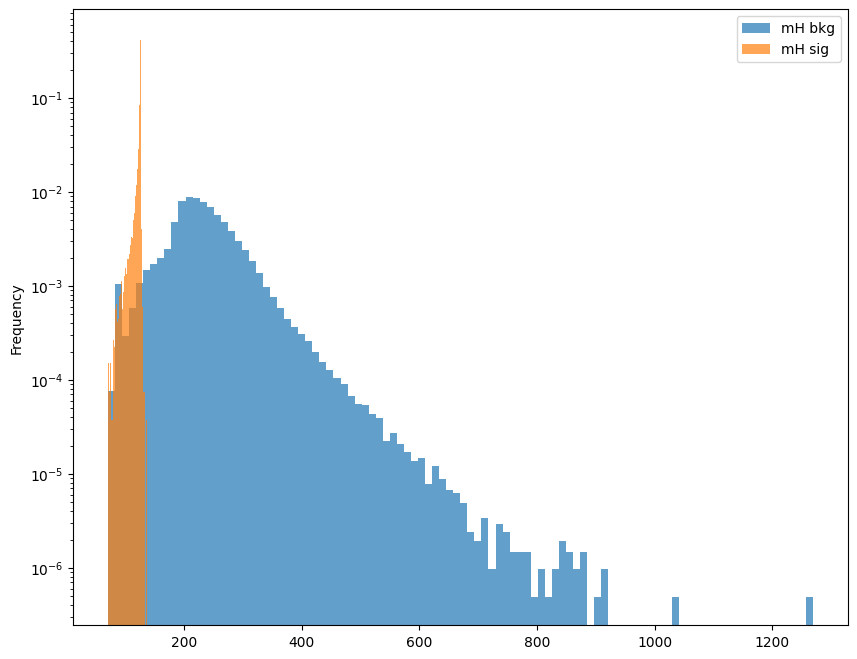

In [30]:
#replot using pandas dataframe and matplotlib this time :)
var_name = "mH"

ax = df[df['Y']==0].plot.hist(column=[var_name], figsize=(10, 8), bins = 100, density = True, alpha=0.7)
ax.set_yscale('log')
df[df['Y']==1].plot.hist(column=[var_name], figsize=(10, 8), bins = 100, density = True, alpha=0.7, ax=ax)
ax.legend(labels=[var_name+' bkg', var_name+' sig'])


Separate features from labels

In [10]:
y = df['Y'].values
X = df[[col for col in features]]

Split into training and test sets

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=0)

Install xgboost libraries

In [12]:
import xgboost as xgb

In [13]:
print("Training on %i examples with %i features"%X_train.shape)

#Use default parameters and train on full dataset
mymodel = xgb.sklearn.XGBRegressor(objective='binary:logistic',
                                 max_depth        = 4,
                                 learning_rate    = 0.07,
                                 n_estimators     = 1000,
                                 eval_metric= "auc" #'error',
                                 )
#Train and time classifier
start_time = time.time()
mymodel.fit(X_train, y_train)
run_time = time.time() - start_time

#Make Predictions
print("Predicting on %i examples with %i features\n"%X_test.shape)
y_pred= mymodel.predict(X_test)

#Print Results
print("Model Accuracy: {:.2f}%".format(100*mymodel.score(X_test, y_test)))
print("The AUC score is {:.2f}".format(roc_auc_score(y_test,y_pred)))
print("Run time: {:.2f} sec\n\n".format(run_time))


Training on 183685 examples with 7 features
Predicting on 20410 examples with 7 features

Model Accuracy: 56.52%
The AUC score is 0.96
Run time: 1.59 sec




## Visualizing Feature Importance
One nice aspect of XGBoost (and ensemble methods in general) is that it is easy to visualize feature importances. In XGBoost, there are some handy plots for viewing these (similar functions also exist for the scikit implementation of random forests). One thing we can calculate is the feature importance score (Fscore), which measures how many times each feature was split on. The higher this number, the more fine-tuned the partitions in this direction, and presumably the more informative it is for our classification task.

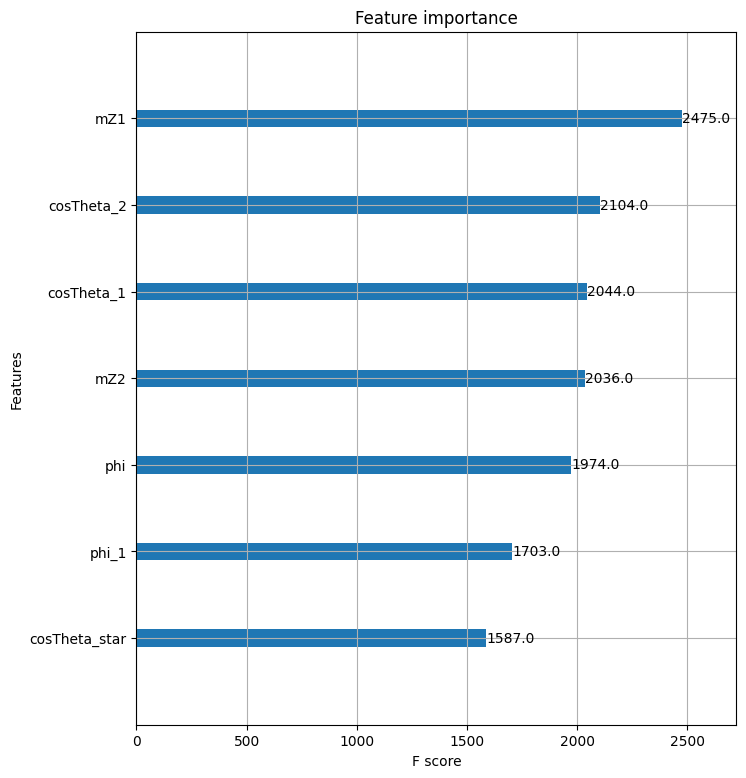

In [14]:
#import ml_style as style
import matplotlib as mpl
#mpl.rcParams.update(style.style)
import matplotlib.pyplot as plt

%matplotlib inline

fig=plt.figure(figsize=(12,9))
xgb.plot_importance(mymodel, ax=plt.gca())
fig.subplots_adjust(left=0.4)  #
#fig.savefig('XGBoost1.pdf')

## Plot ROC curves

This simple example shows that with the default parameters one can already achieve an accuracy of about 80 percent using all the features (kinematic and hand crafted), and a slightly smaller accuracy of about 78.75% using just the kinematic features. Both achieve a very respectable AUC (area under the ROC curve, see https://en.wikipedia.org/wiki/Receiver_operating_characteristic) score of around 0.78 or 0.79. This is significantly better than that achieved using Boosted Decision Trees (though not deep neural networks) in the original paper, even without tuning hyperparameters. Furthermore, we are using only a small subset of all the data (100,000 out of a total of 5,000,000 datapoints) so this performance is a lower bound on what can be accomplished with XGBoost. Note that there are only three points on the curve so the ROC does not contain much information beyond the accuracy.

We can summarize this by plotting the ROC curves for these three models. Recall that ROC curves plot the true positive rate. Here, we will use the modified version used in high-energy physics plotting the true negative rate (Background rejection) against the true positive rate (signal efficiency).

Text(0, 0.5, 'Background Rejection')

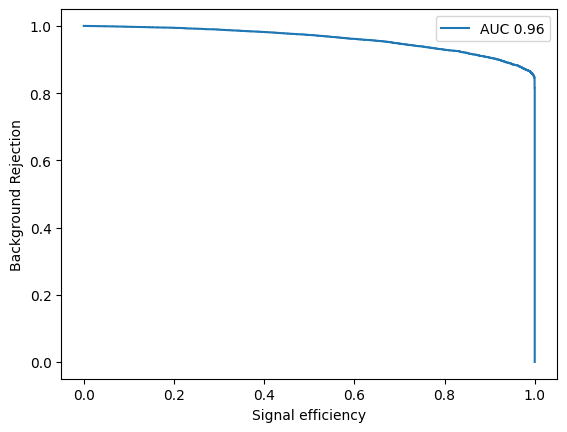

In [15]:
from sklearn.metrics import roc_curve


%matplotlib inline
y_pred= mymodel.predict(X_test)
fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred.ravel())
plt.figure(1)
plt.plot(tpr, 1-fpr, label="AUC {:.2f}".format(roc_auc_score(y_test,y_pred)))
plt.legend(loc=1)
plt.xlabel('Signal efficiency')
plt.ylabel('Background Rejection')
#plt.savefig("roc_XGBoost.pdf")

## Optimizing XGBoost

We will now optimize the parameters of the XGBoost algorithm by performing a grid search. We will use the very useful new function from scikit-learn GridSearchCV(). This function allows you to specify lists of parameters to search over.

Let us briefly discuss what parameters we can tune to improve performance with descriptions:

max_depth [default=6]: maximum depth of a tree, increasing this value will make the model more complex / likely to overfit.

eta or 'learning_rate'[default =0.3]: step size shrinkage used in update to prevent overfitting. After each boosting step, we can directly get the weights of new features. eta actually shrinks the feature weights to make the boosting process more conservative.

gamma or min-split-loss [default=0]: This is the penalty that regularizes the number of leaves. The larger, the more conservative the algorithm will be.

min_child_weight [default=1]: In linear regression mode, this simply corresponds to the minimum number of instances needed to be in each node (min  in notation of manuscript). The larger, the more conservative the algorithm will be. More generally, it is the minimum sum of instance weight (Hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning.

As you can see this cross-validation procedure is quite computationally expensive. With the parameters below, it takes somewhere between 2 and 5 minutes on a powerful laptop. In the cell below, we perform the search and examine the results in the subsequent results.

In [16]:
print(y_train)

[1 0 1 ... 1 0 1]


In [17]:
from sklearn.model_selection import GridSearchCV

#Create values to search over
cv_params = {'max_depth': [3,4,6], 'min_child_weight': [1,3,5], 'learning_rate':[0.01,0.4]}
model = xgb.sklearn.XGBRegressor(objective='binary:logistic',
                                 n_estimators     = 200,
                                 eval_metric= "auc" #'error',
                                 )
opt_XGBRegressor = GridSearchCV(model,
                                cv_params,
                                scoring = 'neg_mean_squared_error', 
                                cv = 5, 
                                n_jobs = -1, verbose=True, error_score='raise')

opt_XGBRegressor.fit(X_train, y_train)
print(opt_XGBRegressor.best_score_)
print(opt_XGBRegressor.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
-0.057350958672686435
{'learning_rate': 0.4, 'max_depth': 3, 'min_child_weight': 3}


In [18]:
#Print scores
print('The optimal score on training set is {:0.3f}'.format(opt_XGBRegressor.best_score_))

#Find optimal parameters

print('The optimal parameters for the classifier are:')
print(opt_XGBRegressor.best_params_)

#Fit performance on the test set
XGBRegressor_final=opt_XGBRegressor.best_estimator_
y_pred_final=XGBRegressor_final.predict(X_test)
print("Model Accuray with optimal parameters: {:.2f}%".format(100*XGBRegressor_final.score(X_test, y_test)))
print("The  AUC score is {:.2f}".format(roc_auc_score(y_test,y_pred_final)))

The optimal score on training set is -0.057
The optimal parameters for the classifier are:
{'learning_rate': 0.4, 'max_depth': 3, 'min_child_weight': 3}
Model Accuray with optimal parameters: 55.92%
The  AUC score is 0.96


# Overtraining checks

In [19]:
from scipy.stats import ks_2samp

def plot_checks(model, X_test, y_test, X_train, y_train):
    y_pred_test = mymodel.predict(X_test)
    y_pred_train = mymodel.predict(X_train)

    y_pred_test_sig = y_pred_test[ y_test[:]==1] 
    y_pred_test_bkg = y_pred_test[ y_test[:]==0] 

    y_pred_train_sig = y_pred_train[ y_train[:]==1] 
    y_pred_train_bkg = y_pred_train[ y_train[:]==0] 

    #Kolmogorov-Smirnov test of distributions:
    print(ks_2samp(y_pred_test_sig, y_pred_train_sig))
    
    plt.clf()
    plt.figure(figsize=(6.6,6.6))
    plt.hist(y_pred_test_sig, bins=50, range=(0.0, 1.0), histtype='step', density=True)
    plt.hist(y_pred_train_sig, bins=50, range=(0.0, 1.0), histtype='step', density=True)
    plt.xlabel('bdt score', fontsize=14)
    plt.ylabel('Events', fontsize=14)
    plt.show()

    plt.clf()
    plt.figure(figsize=(6.6,6.6))
    plt.hist(y_pred_test_bkg, bins=50, range=(0.0, 1.0), histtype='step', density=True)
    plt.hist(y_pred_train_bkg, bins=50, range=(0.0, 1.0), histtype='step', density=True)
    plt.yscale('log')
    plt.show()

    fpr_test, tpr_test, _ = roc_curve(y_test.ravel(), y_pred_test.ravel())
    fpr_train, tpr_train, _ = roc_curve(y_train.ravel(), y_pred_train.ravel())

    plt.figure(1)
    plt.plot(tpr, 1-fpr, label="test AUC {:.2f}".format(roc_auc_score(y_test,y_pred_test)))
    plt.plot(tpr, 1-fpr, label="train AUC {:.2f}".format(roc_auc_score(y_train,y_pred_train)))
    
    plt.legend(loc=1)
    plt.xlabel('Signal efficiency')
    plt.ylabel('Background Rejection')
    #plt.savefig("roc_XGBoost.pdf")


KstestResult(statistic=0.04901458738079523, pvalue=1.6280958663389042e-06, statistic_location=0.5324349, statistic_sign=1)


<Figure size 640x480 with 0 Axes>

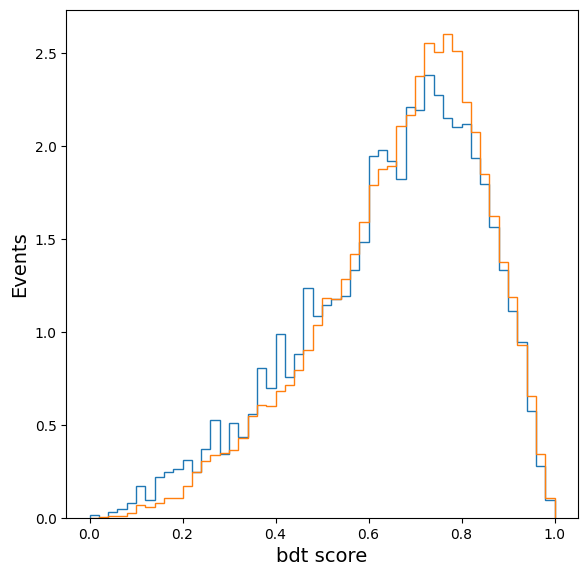

<Figure size 640x480 with 0 Axes>

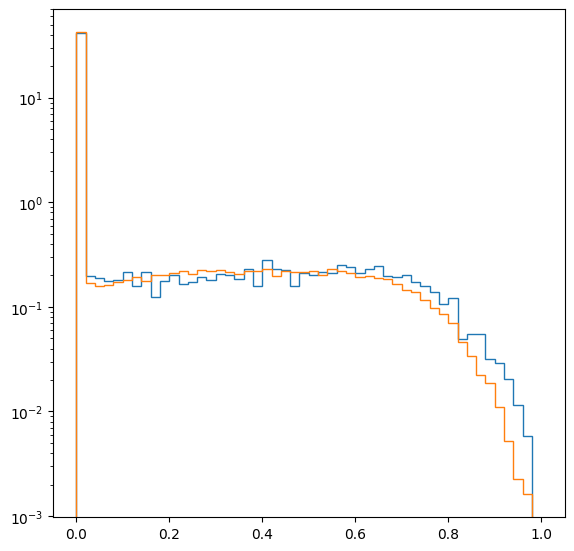

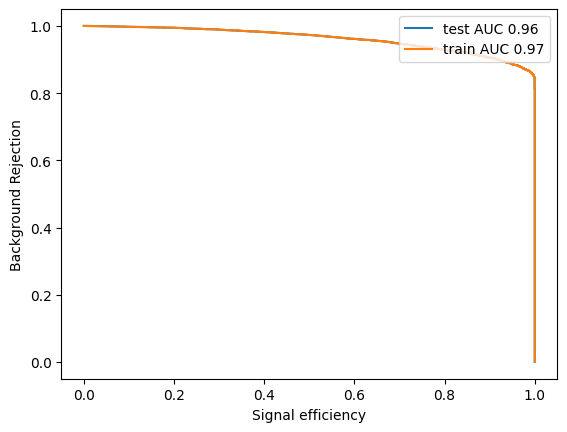

In [20]:
plot_checks(mymodel, X_test, y_test, X_train, y_train)

# Regularisation parameters

In [21]:
#Use default parameters and train on full dataset
mymodel2 = xgb.sklearn.XGBRegressor(objective='binary:logistic',
                                 max_depth        = 3,
                                 learning_rate    = 0.05,
                                 n_estimators     = 1000,
                                 subsample        = 0.7,
                                 colsample_bytree = 0.8,
                                 min_child_weight = 3,
                                 gamma            = 10,
                                 reg_alpha        = 2,
                                 reg_lambda       = 7,
                                 early_stopping_rounds = 10,
                                 eval_metric= "auc" #'error',
                                 )

#Train and time classifier
start_time = time.time()
#Note: with earli stopping you now need the validation set!
mymodel2.fit(X_train, y_train,
            verbose = True,
            eval_set=[(X_train, y_train), (X_test, y_test)]
)

run_time = time.time() - start_time

#Make Predictions
print("Predicting on %i examples with %i features\n"%X_test.shape)
y_pred= mymodel2.predict(X_test)

#Print Results
print("Model Accuracy: {:.2f}%".format(100*mymodel2.score(X_test, y_test)))
print("The AUC score is {:.2f}".format(roc_auc_score(y_test,y_pred)))
print("Run time: {:.2f} sec\n\n".format(run_time))

[0]	validation_0-auc:0.92457	validation_1-auc:0.92399
[1]	validation_0-auc:0.93962	validation_1-auc:0.93857
[2]	validation_0-auc:0.94407	validation_1-auc:0.94286
[3]	validation_0-auc:0.93893	validation_1-auc:0.93807
[4]	validation_0-auc:0.94357	validation_1-auc:0.94263
[5]	validation_0-auc:0.94559	validation_1-auc:0.94470
[6]	validation_0-auc:0.94667	validation_1-auc:0.94553
[7]	validation_0-auc:0.94802	validation_1-auc:0.94648
[8]	validation_0-auc:0.94806	validation_1-auc:0.94648
[9]	validation_0-auc:0.94794	validation_1-auc:0.94651
[10]	validation_0-auc:0.94819	validation_1-auc:0.94664
[11]	validation_0-auc:0.94828	validation_1-auc:0.94666
[12]	validation_0-auc:0.94890	validation_1-auc:0.94726
[13]	validation_0-auc:0.94891	validation_1-auc:0.94735
[14]	validation_0-auc:0.94854	validation_1-auc:0.94706
[15]	validation_0-auc:0.94881	validation_1-auc:0.94727
[16]	validation_0-auc:0.94923	validation_1-auc:0.94773
[17]	validation_0-auc:0.95010	validation_1-auc:0.94851
[18]	validation_0-au

KstestResult(statistic=0.04901458738079523, pvalue=1.6280958663389042e-06, statistic_location=0.5324349, statistic_sign=1)


<Figure size 640x480 with 0 Axes>

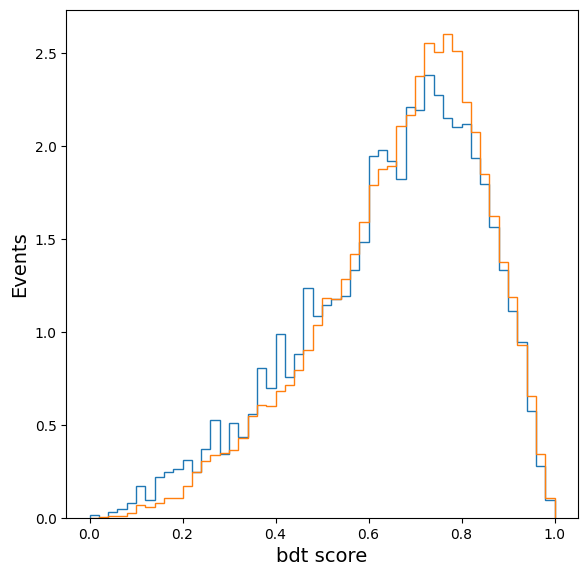

<Figure size 640x480 with 0 Axes>

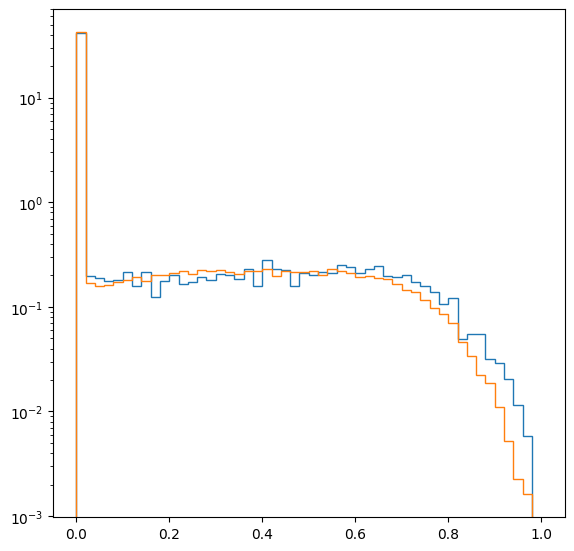

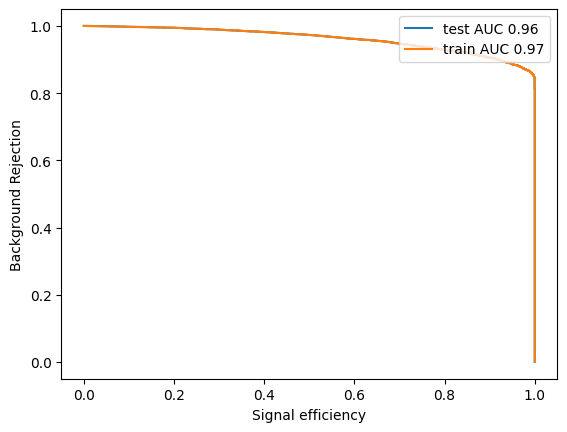

In [22]:
plot_checks(mymodel2, X_test, y_test, X_train, y_train)